<a href="https://colab.research.google.com/github/prateeksrivastava07/NN-and-CNN/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import PIL.Image as Image

In [2]:
classifier_url="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"   # URL of MobileNet v2 pretrained model. This model is trained over (224,224) size images with channel 3

In [3]:
imS=(224,224) # imS is Imageshape

In [4]:
 # c is our classifier
c=tf.keras.Sequential([
hub.KerasLayer(classifier_url,input_shape=imS+(3,)) # input image shape is (224,224,3)
])

In [5]:
#Now we will find the level corresponding to this id pc
lp=tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

16384/10484 [==============================================] - 0s 0us/step


In [6]:
#imagenet labels
imgNet_labels=np.array(open(lp).read().splitlines())

In [7]:
I=Image.open(r'/content/car.jpg').resize(imS)  # tig.jpg is some image of tiger at my drive. for this practical it is uploaded at google drive

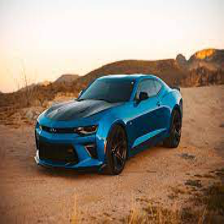

In [8]:
I # display the image.

In [9]:
# normalize the image
I=np.array(I)/255
I.shape

(224, 224, 3)

In [10]:
# Now let we check the result of classifier as "r"
r=c.predict(I[np.newaxis,...]) # add a new axis, This is the way how mobilenet v2 sees the images
r.shape  # 1000 classes are there and one more class ie 'none of the thousand class' is also there hence 1001 classes

(1, 1001)

In [11]:
#Let we check the predicted class id(pc). note: id will be some where betweeb 0 to 1000 ie index value
pc=np.argmax(r[0],axis=-1)
pc

818

Text(0.5, 1.0, 'sports car')

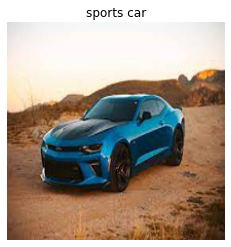

In [12]:
plt.imshow(I) # our actual image
plt.axis('off') # Remove the X and Y Axis
pcn=imgNet_labels[pc] # predicted class name
plt.title(pcn)  #represent predicted class name as title in plot

In [13]:
# So Far we worked with pretrained model and we did nothing. Now let we use this pretrained model in out model for similar type of class predictions
# let we donload data for flowers
data_root=tf.keras.utils.get_file(
'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
untar=True
)

228818944/228813984 [==============================] - 2s 0us/step


In [14]:
# Now we will call image generator to get this data out.
ig=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
imData=ig.flow_from_directory(str(data_root),target_size=imS)

Found 3670 images belonging to 5 classes.


In [15]:
#let we make certain batches
for imB,lbB in imData:
  print(imB.shape)
  print(lbB.shape)
  break;
  #in output you can see: (32,224,224,3) means-32 images in a batch, image size is 224*224 and channel is 3.
#And (32,5) means,for 32 images we have five classes

(32, 224, 224, 3)
(32, 5)


In [16]:
# before using transfer learning in our model let we see the response of built in classifier (ie pretrained network)
rB=c.predict(imB)
rB.shape
# u will find 32 classes among 1001

(32, 1001)

In [17]:
#Now let we check these 32 classes
pcn=imgNet_labels[np.argmax(rB,axis=-1)]
pcn

array(['daisy', 'daisy', 'daisy', 'greenhouse', 'spider web', 'daisy',
       'vase', 'feather boa', 'bee', 'hip', 'cardoon', 'flamingo',
       'harmonica', 'pot', 'rapeseed', 'vase', 'daisy', 'ant', 'mushroom',
       'dragonfly', 'balloon', 'vase', 'bee', 'bee', 'fly', 'rapeseed',
       'daisy', 'cauliflower', 'sea anemone', 'flamingo', 'rapeseed',
       'earthstar'], dtype='<U30')

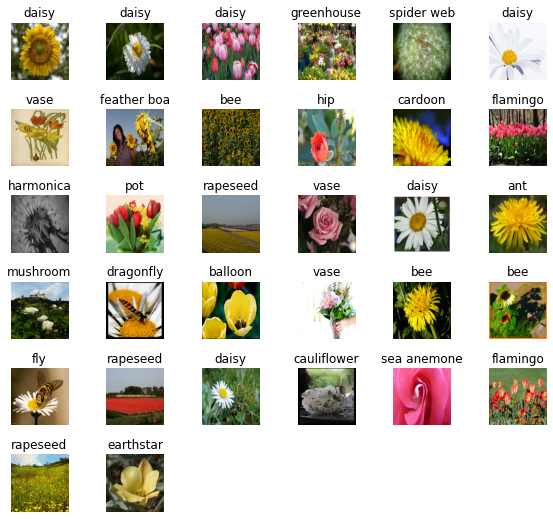

In [18]:
plt.figure(figsize= (10,9))
plt.subplots_adjust(hspace=0.5)
for i in range(32):
  plt.subplot(6,6,i+1)
  plt.imshow(imB[i])
  plt.title(pcn[i])
  plt.axis('off')

In [19]:
#Now let we download the head less model ie feature extractor layers only or fully connected layer less model
headlessmodel_url="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/5"

In [20]:
# Now let we download the headless model means only feature extractor
headlessmodel=hub.KerasLayer(headlessmodel_url,input_shape=imS+(3,))


In [21]:
#Features of Image batch
fimB=headlessmodel(imB)
fimB.shape  #32 image and 1664 features

TensorShape([32, 1664])

In [22]:
# set headless model to non trainable
headlessmodel.trainable=False

In [23]:
# Now lets build our model
myModel=tf.keras.Sequential([
headlessmodel,
tf.keras.layers.Dense(imData.num_classes,activation='softmax')    
]) # imData.num_classes represents total number of classes here it is 5

In [24]:
myModel.compile(
optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['acc']    
)

In [25]:
myModel.fit(imData,epochs=3)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


115/115 [==============================] - 129s 1s/step - loss: 0.5600 - acc: 0.8022
Epoch 2/3
115/115 [==============================] - 125s 1s/step - loss: 0.2625 - acc: 0.9166
Epoch 3/3
115/115 [==============================] - 125s 1s/step - loss: 0.2019 - acc: 0.9379


In [28]:
# let we create class name
cn=np.array(['Daisy','Dandelion','Roses','Sunflowers','Tulips']) # index from 0 to 4

In [29]:
prediction=myModel.predict(imB)
predicted_ids=np.argmax(prediction,axis=-1)
pcn=cn[predicted_ids]

In [31]:
# Now lets see the actual labels
l_ids=np.argmax(lbB,axis=-1) # original labels of batch

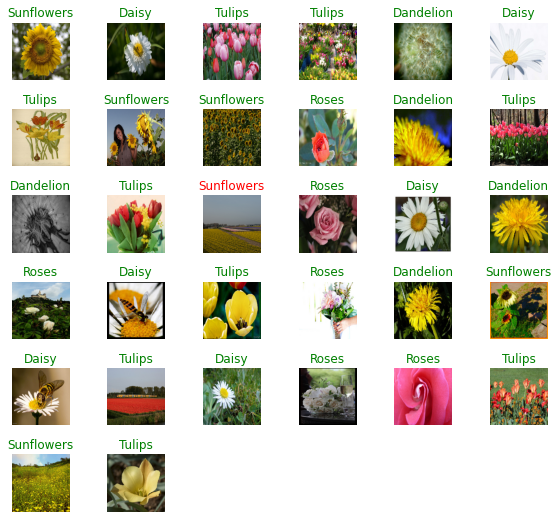

In [36]:
# let we plot the images
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for i in range(32):
  plt.subplot(6,6,i+1)
  plt.imshow(imB[i])
  color='green' if predicted_ids[i]==l_ids[i] else 'red'
  plt.title(pcn[i].title(),color=color)
  plt.axis('off')